In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Viz data

In [2]:
# airplanes = os.listdir('/home/m_bobrin/enot_website/data/ShapeNetCore.v2.PC15k/02691156/train')

# fig = plt.figure(figsize=(20, 20)) 
# for ind in range(16):
#     ax = fig.add_subplot(4, 4, 1+ind, projection='3d')
#     i = np.random.randint(len(airplanes))
#     cur_plaine = np.load(f'/home/m_bobrin/enot_website/data/ShapeNetCore.v2.PC15k/02691156/train/{airplanes[i]}')
#     ax.scatter(cur_plaine[:, 2], cur_plaine[:, 0], cur_plaine[:, 1],
#                c=cur_plaine[:, 0], cmap='viridis')
#     plt.axis('equal')
    
# plt.show()

In [3]:
# airplanes = os.listdir('/home/m_bobrin/enot_website/data/ShapeNetCore.v2.PC15k/02691156/val')
# fig = make_subplots(rows=4, cols=4, specs=[[{'type': 'scatter3d'}]*4]*4)

# for ind in range(16):
#     cur_plaine = np.load(f'/home/m_bobrin/enot_website/data/ShapeNetCore.v2.PC15k/02691156/val/{airplanes[ind]}')
#     fig.add_trace(go.Scatter3d(
#         x=-cur_plaine[:, 2],
#         y=cur_plaine[:, 0],
#         z=cur_plaine[:, 1],
#         mode='markers',
#         marker=dict(size=3, color=cur_plaine[:, 0], colorscale='Viridis', opacity=0.8)
#     ), row=ind//4+1, col=ind%4+1)
# fig.update_layout(title='3D Scatter Plot of Point Cloud Data', scene=dict(aspectmode='data'), width=1200, height=1200)
# fig.show()

In [4]:
# fig = go.Figure(data=[go.Scatter3d(
#     x=-test[:, 2],
#     y=test[:, 0],
#     z=test[:, 1],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=test[:, 0],
#         colorscale='Viridis',
#         opacity=0.8
#     )
# )])
# fig.update_layout(title='3D Scatter Plot of Point Cloud Data',
#                   scene=dict(aspectmode='data'))
# fig.show()

# OTT

In [4]:
import ott
from ott.neural.methods.expectile_neural_dual import ExpectileNeuralDual

In [6]:
# noises = jax.random.normal(jax.random.PRNGKey(0), (16, 1000, 3))

# fig = plt.figure(figsize=(20, 20)) 
# for ind in range(16):
#     ax = fig.add_subplot(4, 4, 1+ind, projection='3d')
#     ax.scatter(noises[ind][:, 2], noises[ind][:, 0], noises[ind][:, 1],
#                c=noises[ind][:, 0], cmap='viridis')
#     plt.axis('equal')
    
# plt.show()

In [5]:
from functools import partial
from dataclasses import dataclass
from typing import Iterator
#planes_numpy_array = jnp.stack([np.load(f'/home/m_bobrin/enot_website/data/ShapeNetCore.v2.PC15k/02691156/train/{airplanes[i]}') for i in range(len(airplanes))])

plane = jnp.asarray(np.load("/home/nazar/projects/plane_data.npy"))
# indx = np.random.randint(plane.shape[0])
# test_sample = planes_numpy_array[indx]
mean_sample = jnp.mean(plane, axis=0)
std_sample = jnp.std(plane, axis=0)

class PlanesDataset:
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield PlanesDataset._sample(sample_key, self.batch_size)

    @staticmethod
    @partial(jax.jit, static_argnums=(1,))
    def _sample(key, batch_size):
        indx = jax.random.randint(key, (batch_size,), 0, plane.shape[0])
        return plane[indx]

class NoiseDataset:
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield NoiseDataset._sample(sample_key, self.batch_size)

    @staticmethod
    @partial(jax.jit, static_argnums=(1,))
    def _sample(key, batch_size):
        return jax.random.normal(key, (batch_size, 3)) * std_sample + mean_sample
    
@dataclass
class TrainLoader:
    src_loader: Iterator[jnp.ndarray]
    tgt_loader: Iterator[jnp.ndarray]


(-0.41837948560714716,
 0.3868741393089294,
 -0.4025978744029998,
 0.4026557505130767,
 -0.26364023983478546,
 0.34029997885227203)

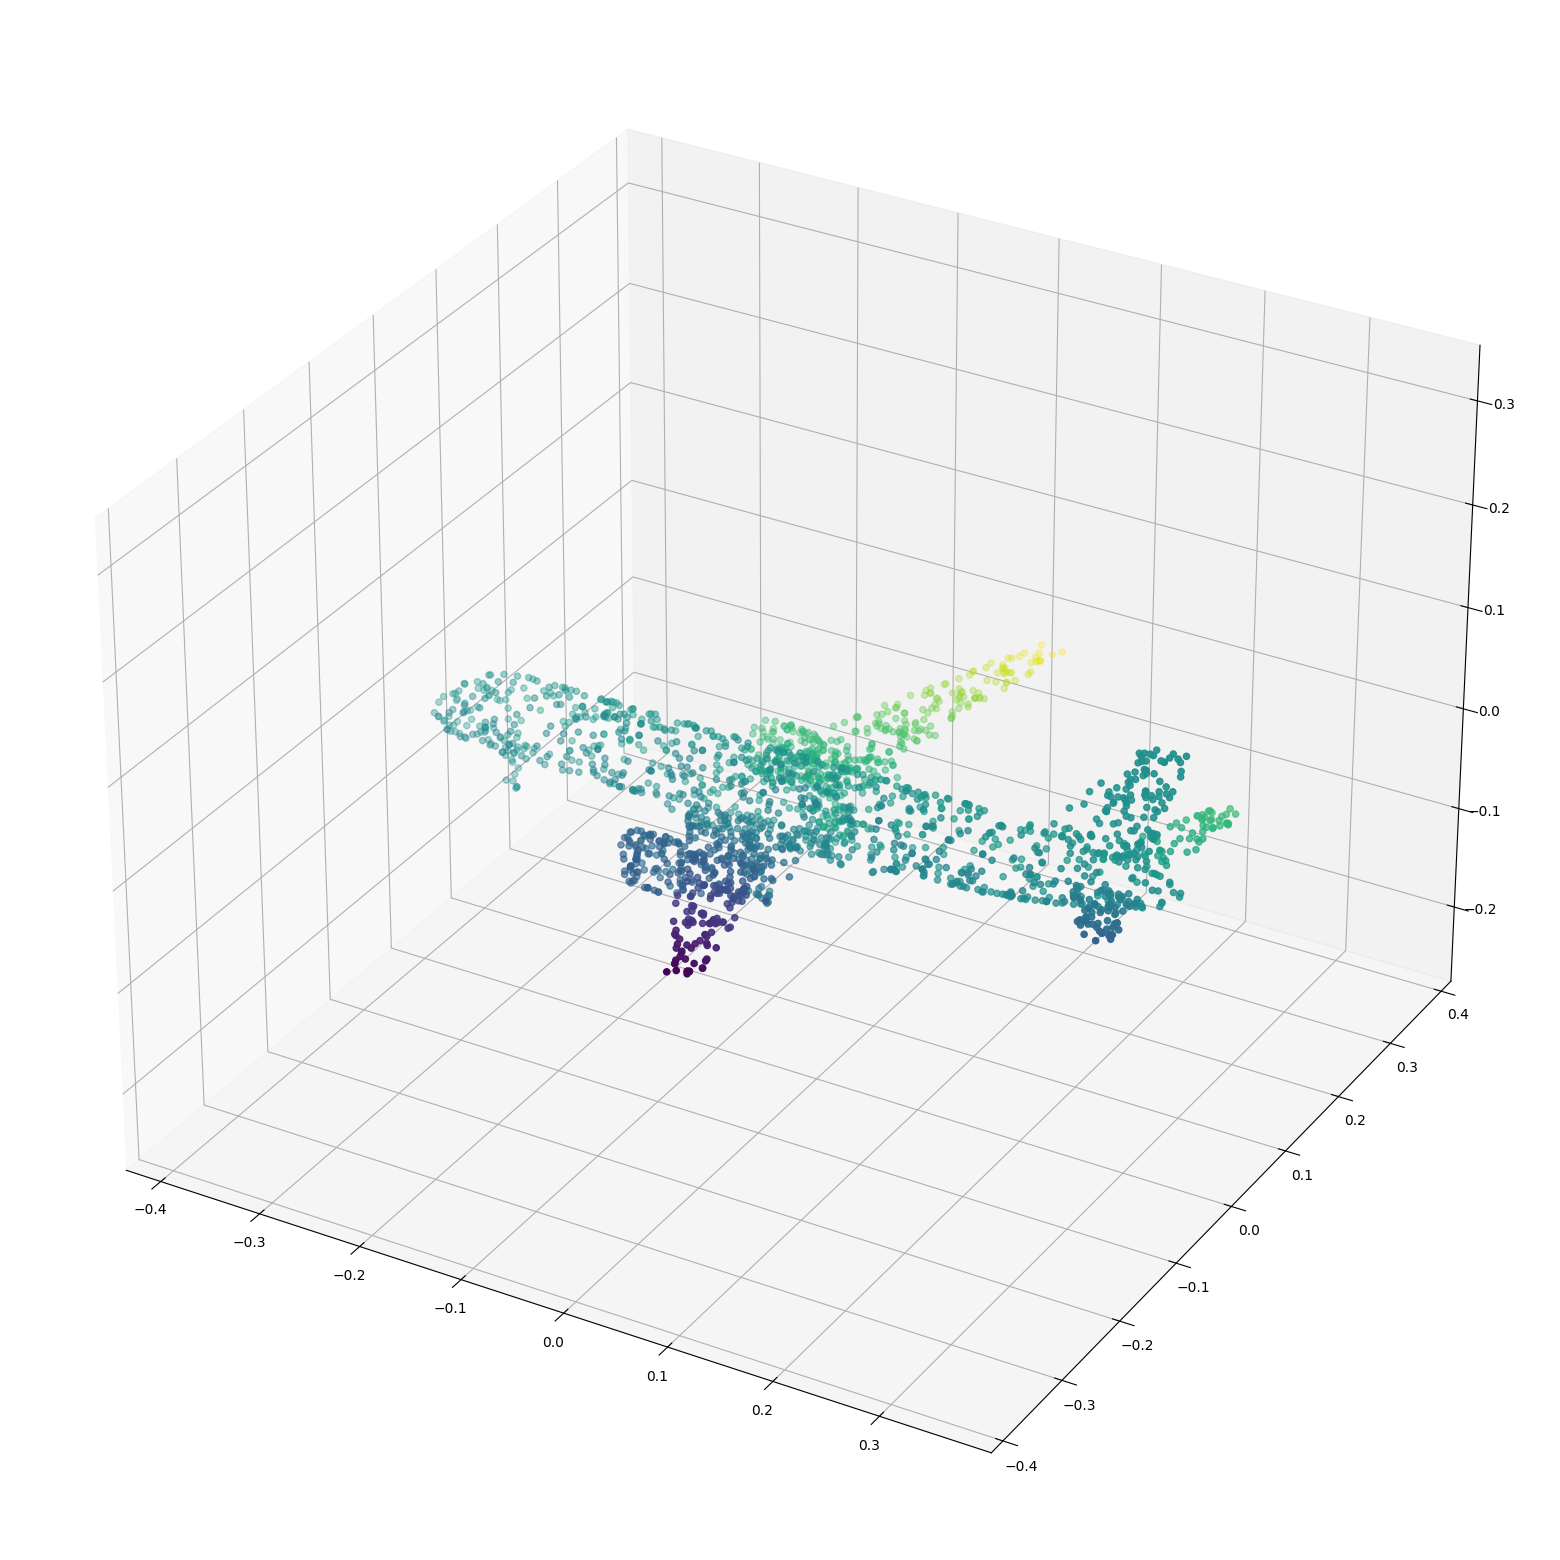

In [8]:
import flax
import flax.linen as nn
from ott.neural.networks.potentials import MLP
import optax

enot_loader = TrainLoader(iter(NoiseDataset(2048)), iter(PlanesDataset(2048)))
neural_f = MLP(dim_hidden=[256, 256, 256, 256, 1], act_fn=jax.nn.elu)
neural_g = MLP(dim_hidden=[256, 256, 256, 256, 1], act_fn=jax.nn.elu)

enot = ExpectileNeuralDual(
    dim_data=3,
    neural_f=neural_f,
    neural_g=neural_g,
    is_bidirectional=True,
    optimizer_f=optax.adam(learning_rate=3e-4, b1=0.9, b2=0.999),
    optimizer_g=optax.adam(learning_rate=3e-4, b1=0.9, b2=0.999),
    num_train_iters=90_000,
    logging=True,
)

fig = plt.figure(figsize=(20, 20))
img = next(enot_loader.tgt_loader)

ax = fig.add_subplot(projection='3d')
ax.scatter(img[:, 2], img[:, 0], img[:, 1],
            c=img[:, 0], cmap='viridis')
plt.axis('equal')

In [9]:
potentials, logs =enot(trainloader_source=enot_loader.src_loader, trainloader_target=enot_loader.tgt_loader,
     validloader_source=enot_loader.src_loader, validloader_target=enot_loader.tgt_loader)

  0%|          | 0/90000 [00:00<?, ?it/s]

(-0.41156438142061236,
 0.38156759887933733,
 -0.3960911050438881,
 0.3970408752560616,
 -0.24162194617092608,
 0.35322703905403613)

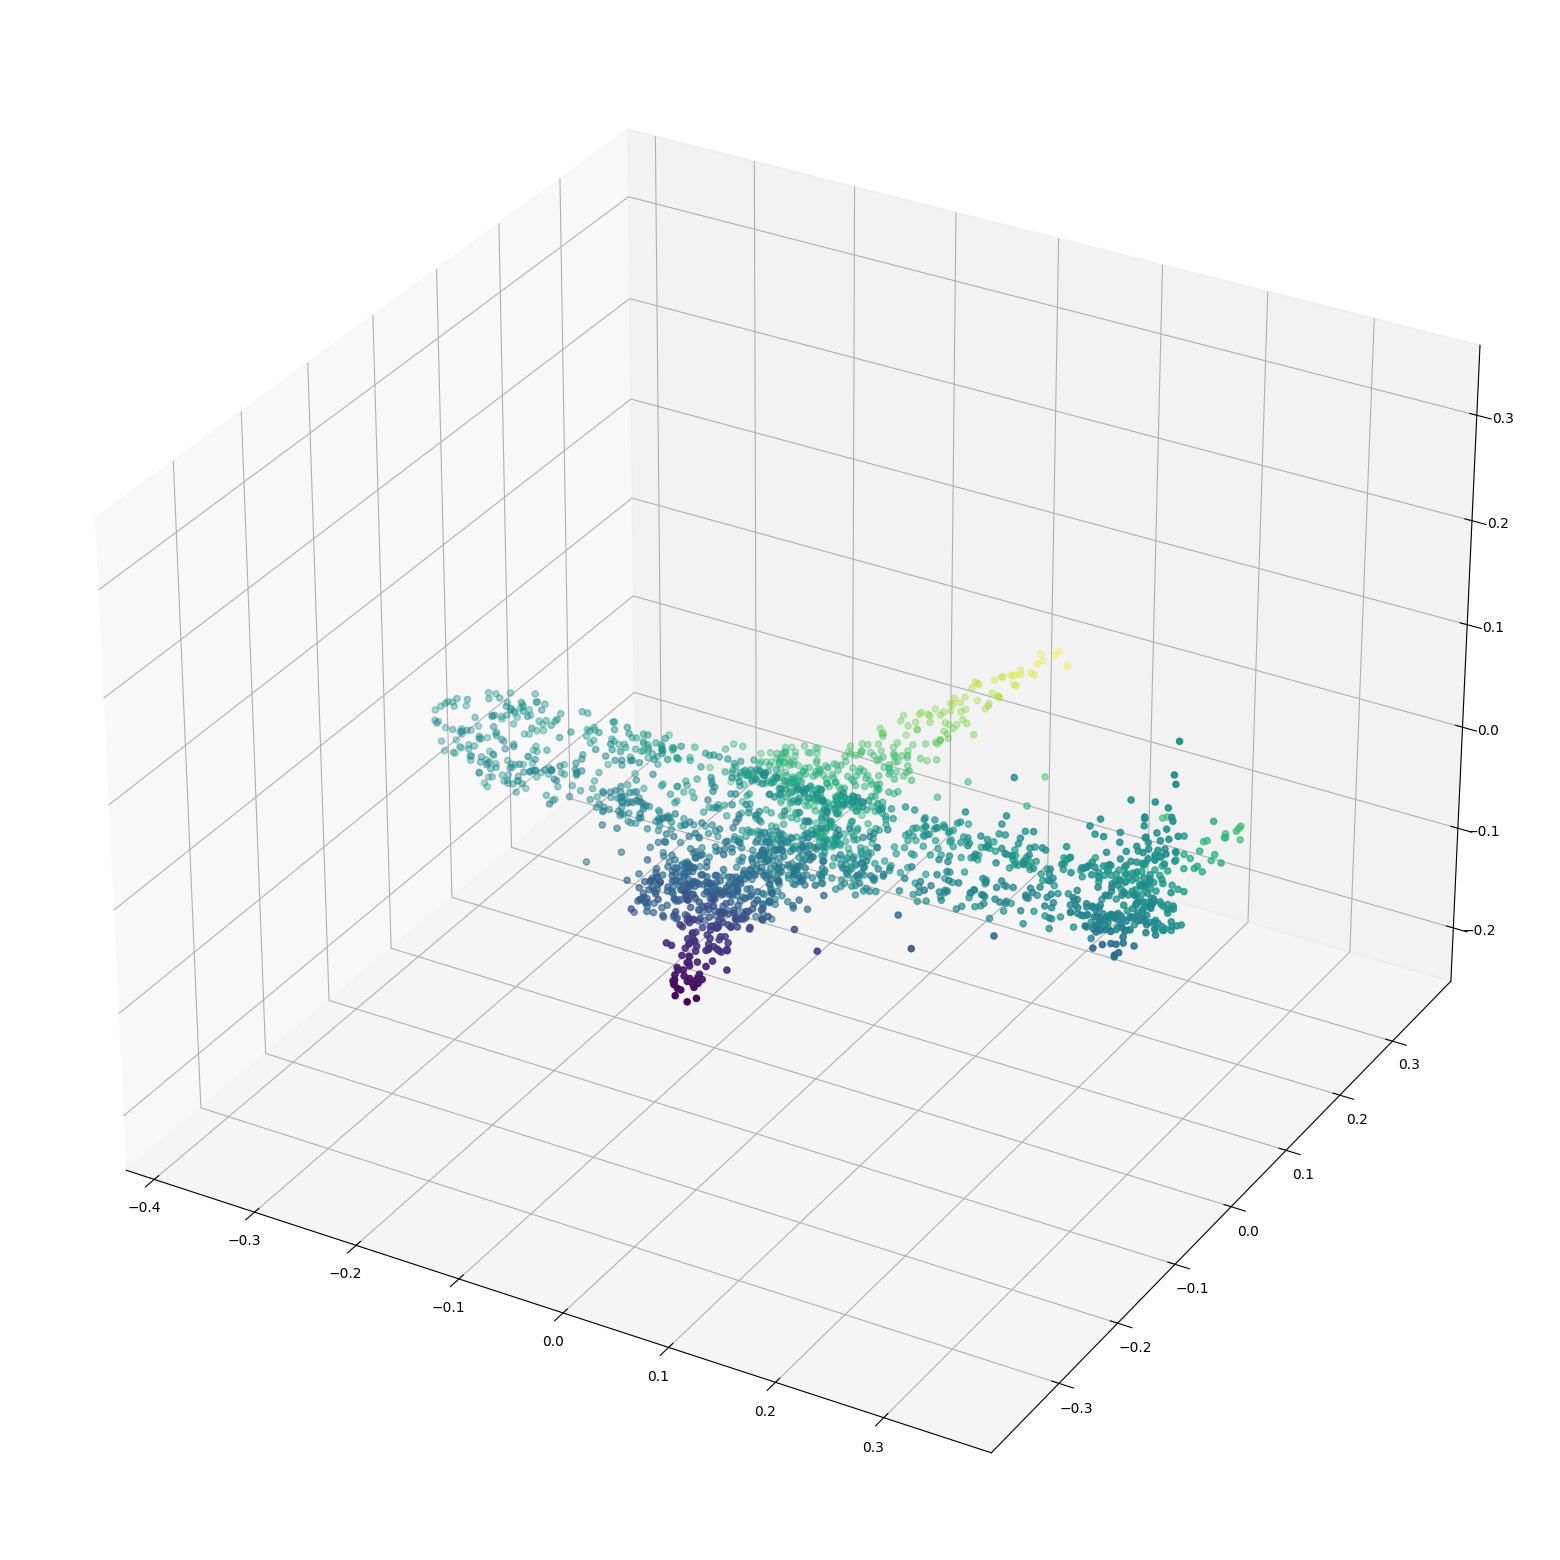

In [12]:
pred = potentials.transport(next(enot_loader.src_loader))
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(pred[:, 2], pred[:, 0], pred[:, 1],
            c=pred[:, 0], cmap='viridis')
plt.axis('equal')